First you want to create a problem which solves multiple problems at the same time. This is the Monte Carlo Problem. When the parameter estimation tools say it will take any DEProblem, it really means ANY DEProblem!

So, let's get a Monte Carlo problem setup that solves with 10 different initial conditions.
# Monte Carlo Parameter Estimation From Data
### Chris Rackauckas

In [3]:
using DifferentialEquations, DiffEqParamEstim, Plots, Optim

# Monte Carlo Problem Set Up for solving set of ODEs with different initial conditions

# Set up Lotka-Volterra system
function pf_func(du,u,p,t)
  du[1] = p[1] * u[1] - p[2] * u[1]*u[2]
  du[2] = -3 * u[2] + u[1]*u[2]
end
p = [1.5,1.0]
prob = ODEProblem(pf_func,[1.0,1.0],(0.0,10.0),p)

┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1186


ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: [1.0, 1.0]

Now for a MonteCarloProblem we have to take this problem and tell it what to do N times via the prob_func. So let's generate N=10 different initial conditions, and tell it to run the same problem but with these 10 different initial conditions each time:

In [4]:
# Setting up to solve the problem N times (for the N different initial conditions)
N = 10;
initial_conditions = [[1.0,1.0], [1.0,1.5], [1.5,1.0], [1.5,1.5], [0.5,1.0], [1.0,0.5], [0.5,0.5], [2.0,1.0], [1.0,2.0], [2.0,2.0]]
function prob_func(prob,i,repeat)
  ODEProblem(prob.f,initial_conditions[i],prob.tspan,prob.p)
end
monte_prob = MonteCarloProblem(prob,prob_func=prob_func)

MonteCarloProblem with problem ODEProblem

We can check this does what we want by solving it:

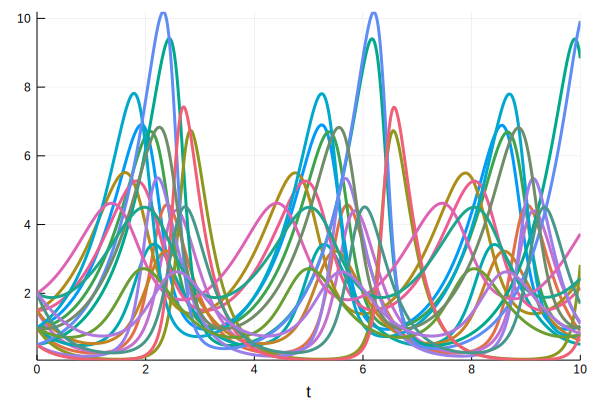

In [5]:
# Check above does what we want
sim = solve(monte_prob,Tsit5(),num_monte=N)
plot(sim)

num_monte=N means "run N times", and each time it runs the problem returned by the prob_func, which is always the same problem but with the ith initial condition.

Now let's generate a dataset from that. Let's get data points at every t=0.1 using saveat, and then convert the solution into an array.

In [6]:
# Generate a dataset from these runs
data_times = 0.0:0.1:10.0
sim = solve(monte_prob,Tsit5(),num_monte=N,saveat=data_times)
data = Array(sim)

2×101×10 Array{Float64,3}:
[:, :, 1] =
 1.0  1.06108   1.14403   1.24917   1.37764   …  0.956979  0.983561  1.03376 
 1.0  0.821084  0.679053  0.566893  0.478813     1.35559   1.10629   0.906371

[:, :, 2] =
 1.0  1.01413  1.05394  1.11711   …  1.05324  1.01309  1.00811  1.03162
 1.5  1.22868  1.00919  0.833191     2.08023  1.70818  1.39973  1.14803

[:, :, 3] =
 1.5  1.58801   1.70188   1.84193   2.00901   …  2.0153    2.21084   2.43589 
 1.0  0.864317  0.754624  0.667265  0.599149     0.600942  0.549793  0.513679

[:, :, 4] =
 1.5  1.51612  1.5621   1.63555   1.73531   …  1.83823   1.98545   2.15958 
 1.5  1.29176  1.11592  0.969809  0.850159     0.771089  0.691421  0.630025

[:, :, 5] =
 0.5  0.531705  0.576474  0.634384  0.706139  …  9.05366   9.4006   8.83911
 1.0  0.77995   0.610654  0.480565  0.380645     0.809382  1.51708  2.82619

[:, :, 6] =
 1.0  1.11027   1.24238   1.39866   1.58195   …  0.753108  0.748814  0.768284
 0.5  0.411557  0.342883  0.289812  0.249142     1.73879  

Here, data[i,j,k] is the same as sim[i,j,k] which is the same as sim[k][i,j] (where sim[k] is the kth solution). So data[i,j,k] is the jth timepoint of the ith variable in the kth trajectory.

Now let's build a loss function. A loss function is some loss(sol) that spits out a scalar for how far from optimal we are. In the documentation I show that we normally do loss = L2Loss(t,data), but we can bootstrap off of this. Instead lets build an array of N loss functions, each one with the correct piece of data.

In [7]:
# Building a loss function
losses = [L2Loss(data_times,data[:,:,i]) for i in 1:N]

10-element Array{L2Loss{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},Array{Float64,2},Nothing,Nothing,Nothing},1}:
 L2Loss{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},Array{Float64,2},Nothing,Nothing,Nothing}(0.0:0.1:10.0, [1.0 1.06108 … 0.983561 1.03376; 1.0 0.821084 … 1.10629 0.906371], nothing, nothing, nothing, nothing)
 L2Loss{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},Array{Float64,2},Nothing,Nothing,Nothing}(0.0:0.1:10.0, [1.0 1.01413 … 1.00811 1.03162; 1.5 1.22868 … 1.39973 1.14803], nothing, nothing, nothing, nothing)   
 L2Loss{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},Array{Float64,2},Nothing,Nothing,Nothing}(0.0:0.1:10.0, [1.5 1.58801 … 2.21084 2.43589; 1.0 0.864317 … 0.549793 0.513679], nothing, nothing, nothing, nothing)
 L2Loss{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},Array{Float64,2},Noth

So losses[i] is a function which computes the loss of a solution against the data of the ith trajectory. So to build our true loss function, we sum the losses:

In [8]:
loss(sim) = sum(losses[i](sim[i]) for i in 1:N)

loss (generic function with 1 method)

As a double check, make sure that loss(sim) outputs zero (since we generated the data from sim). Now we generate data with other parameters:

In [9]:
prob = ODEProblem(pf_func,[1.0,1.0],(0.0,10.0),[1.2,0.8])
function prob_func(prob,i,repeat)
  ODEProblem(prob.f,initial_conditions[i],prob.tspan,prob.p)
end
monte_prob = MonteCarloProblem(prob,prob_func=prob_func)
sim = solve(monte_prob,Tsit5(),num_monte=N,saveat=data_times)
loss(sim)

10108.695792044306

and get a non-zero loss. So we now have our problem, our data, and our loss function... we have what we need.

Put this into build_loss_objective.

In [10]:
obj = build_loss_objective(monte_prob,Tsit5(),loss,num_monte=N,
                           saveat=data_times)

(::DiffEqObjective{getfield(DiffEqParamEstim, Symbol("##29#34")){Nothing,Bool,Int64,typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR),Base.Iterators.Pairs{Symbol,Any,Tuple{Symbol,Symbol},NamedTuple{(:num_monte, :saveat),Tuple{Int64,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}}},MonteCarloProblem{ODEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{Float64,1},ODEFunction{true,typeof(pf_func),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Nothing,DiffEqBase.StandardODEProblem},typeof(prob_func),getfield(DiffEqBase, Symbol("##378#384")),getfield(DiffEqBase, Symbol("##380#386")),Array{Any,1}},Tsit5,typeof(loss),Nothing},getfield(DiffEqParamEstim, Symbol("##33#39"))}) (generic function with 2 methods)

Notice that I added the kwargs for solve into this. They get passed to an internal solve command, so then the loss is computed on N trajectories at data_times.

Thus we take this objective function over to any optimization package. I like to do quick things in Optim.jl. Here, since the Lotka-Volterra equation requires positive parameters, I use Fminbox to make sure the parameters stay positive. I start the optimization with [1.3,0.9], and Optim spits out that the true parameters are:

In [11]:
lower = zeros(2)
upper = fill(2.0,2)
result = optimize(obj, lower, upper, [1.3,0.9], Fminbox(BFGS()))

Results of Optimization Algorithm
 * Algorithm: Fminbox with BFGS
 * Starting Point: [1.3,0.9]
 * Minimizer: [1.5000000000573428,1.0000000001610496]
 * Minimum: 7.028970e-16
 * Iterations: 4
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.06e-06 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 195
 * Gradient Calls: 195

In [12]:
result

Results of Optimization Algorithm
 * Algorithm: Fminbox with BFGS
 * Starting Point: [1.3,0.9]
 * Minimizer: [1.5000000000573428,1.0000000001610496]
 * Minimum: 7.028970e-16
 * Iterations: 4
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.06e-06 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 195
 * Gradient Calls: 195

Optim finds one but not the other parameter.

I would run a test on synthetic data for your problem before using it on real data. Maybe play around with different optimization packages, or add regularization. You may also want to decrease the tolerance of the ODE solvers via

In [13]:
obj = build_loss_objective(monte_prob,Tsit5(),loss,num_monte=N,
                           abstol=1e-8,reltol=1e-8,
                           saveat=data_times)
result = optimize(obj, lower, upper, [1.3,0.9], Fminbox(BFGS()))

Results of Optimization Algorithm
 * Algorithm: Fminbox with BFGS
 * Starting Point: [1.3,0.9]
 * Minimizer: [1.5007434761923657,1.001238477498098]
 * Minimum: 4.163900e-02
 * Iterations: 5
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.66e-06 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 227
 * Gradient Calls: 227

In [14]:
result

Results of Optimization Algorithm
 * Algorithm: Fminbox with BFGS
 * Starting Point: [1.3,0.9]
 * Minimizer: [1.5007434761923657,1.001238477498098]
 * Minimum: 4.163900e-02
 * Iterations: 5
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.66e-06 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 227
 * Gradient Calls: 227

if you suspect error is the problem. However, if you're having problems it's most likely not the ODE solver tolerance and mostly because parameter inference is a very hard optimization problem.